In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

**Pull in S&P 500 index dataset from Yahoo Finance**

In [2]:
df = pd.read_csv('s_and_p.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-02,2080.760010,2116.479980,2080.760010,2099.199951,2099.199951,20531860000
1,2015-11-09,2096.560059,2096.560059,2022.020020,2023.040039,2023.040039,19691320000
2,2015-11-16,2022.079956,2097.060059,2019.390015,2089.169922,2089.169922,19652690000
3,2015-11-23,2089.409912,2095.610107,2070.290039,2090.110107,2090.110107,11792690000
4,2015-11-30,2090.949951,2104.270020,2042.349976,2091.689941,2091.689941,20459190000


**Check for any null values**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       261 non-null    object 
 1   Open       261 non-null    float64
 2   High       261 non-null    float64
 3   Low        261 non-null    float64
 4   Close      261 non-null    float64
 5   Adj Close  261 non-null    float64
 6   Volume     261 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.4+ KB


**No nulls.. Convert date column to datetime**

In [5]:
df['Date'] = pd.to_datetime(df.Date)


**Convert the date to the index**

In [6]:
df = df.set_index('Date').sort_index()


In [7]:
df = df.resample('M').mean()

In [8]:
df = df[['High','Adj Close']]

In [9]:
df.head()

,High,Adj Close
Date,,
2015-11-30,2101.996045,2078.641992
2015-12-31,2079.015015,2030.712494
2016-01-31,1959.404968,1912.375000
2016-02-29,1946.313989,1922.130029
2016-03-31,2051.600067,2045.122497


In [10]:
df.rename(columns={'High': 'high','Adj Close': 'close'}, inplace=True)

In [11]:
df.head()

,high,close
Date,,
2015-11-30,2101.996045,2078.641992
2015-12-31,2079.015015,2030.712494
2016-01-31,1959.404968,1912.375000
2016-02-29,1946.313989,1922.130029
2016-03-31,2051.600067,2045.122497


In [12]:
df['close'] = round(df.close, 2)

In [13]:
df.head()

,high,close
Date,,
2015-11-30,2101.996045,2078.64
2015-12-31,2079.015015,2030.71
2016-01-31,1959.404968,1912.37
2016-02-29,1946.313989,1922.13
2016-03-31,2051.600067,2045.12


In [14]:
df['high'] = round(df.high, 2)

In [15]:
df.head()

,high,close
Date,,
2015-11-30,2102.00,2078.64
2015-12-31,2079.02,2030.71
2016-01-31,1959.40,1912.37
2016-02-29,1946.31,1922.13
2016-03-31,2051.60,2045.12


# Split data

In [16]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

In [17]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

**Verify Splits**

- Does the length of each df equate to the length of the original df?



In [18]:
print(len(train) + len(validate) + len(test) == len(df))

True


- Does the first row of original df equate to the first row of train?



In [19]:
print(df.head(1) == train.head(1))

            high  close
Date                   
2015-11-30  True   True


- Is the last row of train the day before the first row of validate? And the same for validate to test?

In [20]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,high,close
Date,,
2019-10-31,3023.98,3011.48
2019-11-30,3125.03,3116.20


- Is the last row of test the same as the last row of our original dataframe?



In [21]:
pd.concat([test.tail(1), df.tail(1)])


,high,close
Date,,
2020-10-31,3494.01,3424.07
2020-10-31,3494.01,3424.07


- Let's plot our data first, viewing where the data is split into train and test.



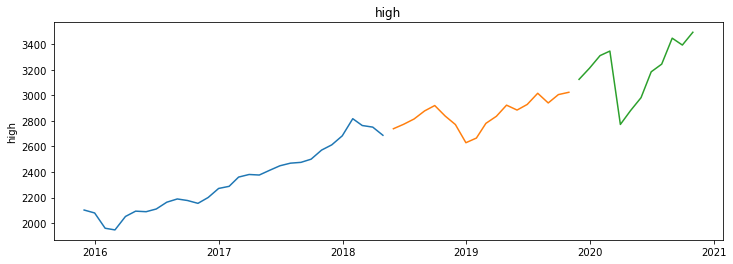

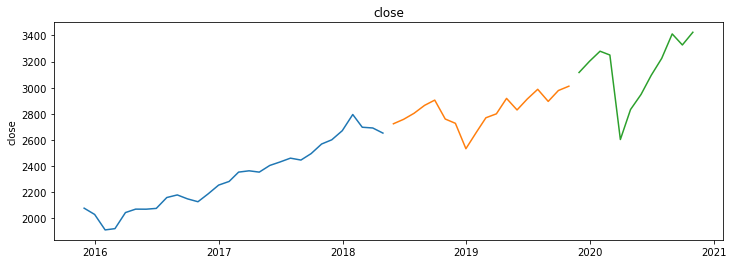

In [22]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

**Create our target variable**

In [23]:
target_var = 'close'


- Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.

- evaluate() will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.

In [24]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

- plot_and_eval() will use the evaluate function and also plot train and test values with the predicted values in order to compare performance

In [25]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [26]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [27]:
eval_df

,model_type,target_var,rmse


# Forecast

**Last Observed Value**

- Make Predictions

In [28]:
close = train['close'][-1:][0]
high = train['high'][-1:][0]

yhat_df = pd.DataFrame({'close': [close], 'high': [high]}, 
                       index = validate.index)

yhat_df.head(2)

,close,high
Date,,
2018-05-31,2652.85,2687.25
2018-06-30,2652.85,2687.25


**Plot Actual vs. Predicted Values**



close -- RMSE: 209


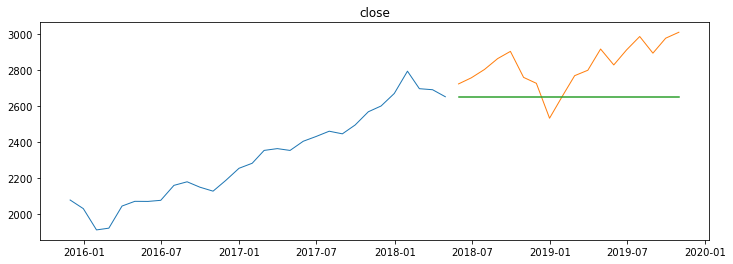

In [29]:
plot_and_eval('close')

high -- RMSE: 200


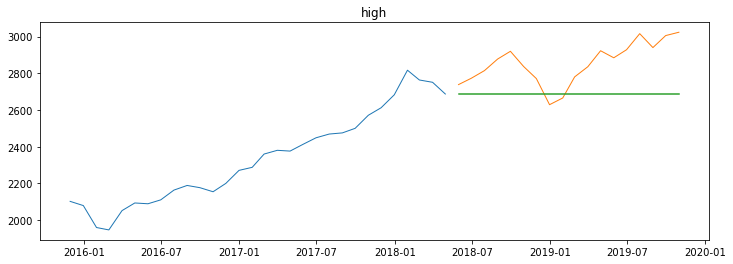

In [30]:
plot_and_eval('high')

# Evaluate

**Evaluate using MSE and RMSE, and add evaluation metrics to eval_df**


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2015-11-30 to 2018-04-30
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   high    30 non-null     float64
 1   close   30 non-null     float64
dtypes: float64(2)
memory usage: 720.0 bytes


In [32]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [33]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,high,200.0
1,last_observed_value,close,209.0


# Simple Average

- Make Predictions



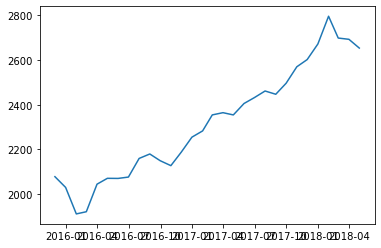

In [34]:
# compute simple average

plt.plot(train['close'])
close = train['close'].mean()

In [35]:
high = train['high'].mean()

In [36]:
# Aplly predictions to our observations

def make_predictions():
    yhat_df = pd.DataFrame({'close': [close],
                           'high': [high]},
                          index= validate.index)
    return yhat_df

In [37]:
yhat_df = make_predictions()

In [38]:
yhat_df.head(2)


,close,high
Date,,
2018-05-31,2318.161333,2339.351333
2018-06-30,2318.161333,2339.351333


**Plot actual vs. predicted**

high -- RMSE: 526


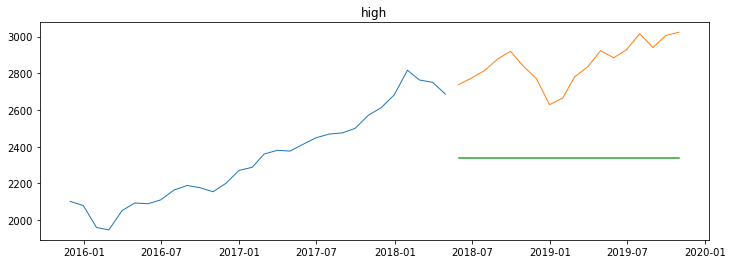

close -- RMSE: 520


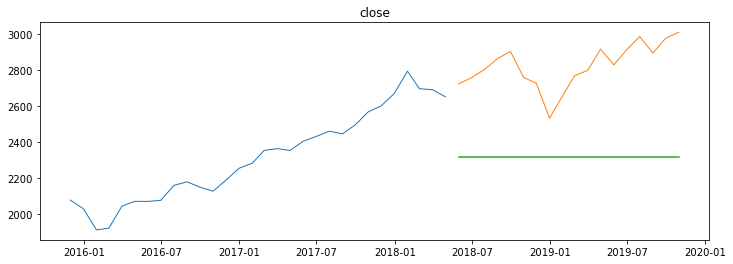

In [39]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [40]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average',
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,high,200.0
1,last_observed_value,close,209.0
2,simple_average,high,526.0
3,simple_average,close,520.0


# Moving Average

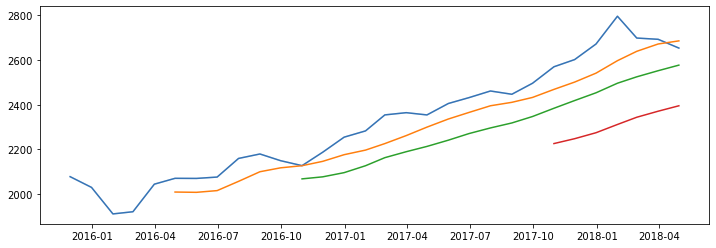

In [41]:

plt.figure(figsize=(12,4))
plt.plot(train['close'].rolling(1).mean())
plt.plot(train['close'].rolling(6).mean())
plt.plot(train['close'].rolling(12).mean())
plt.plot(train['close'].rolling(24).mean())
plt.plot(train['close'], alpha=.2)

**Make Predictions**

In [42]:
train['close'].head(1).mean()
train['close'].rolling(1).mean()

Date
2015-11-30    2078.64
2015-12-31    2030.71
2016-01-31    1912.37
2016-02-29    1922.13
2016-03-31    2045.12
2016-04-30    2071.30
2016-05-31    2070.85
2016-06-30    2076.91
2016-07-31    2160.07
2016-08-31    2179.96
2016-09-30    2149.98
2016-10-31    2127.89
2016-11-30    2187.91
2016-12-31    2255.06
2017-01-31    2283.01
2017-02-28    2354.43
2017-03-31    2364.39
2017-04-30    2354.34
2017-05-31    2405.36
2017-06-30    2431.66
2017-07-31    2461.18
2017-08-31    2446.62
2017-09-30    2495.81
2017-10-31    2569.32
2017-11-30    2601.45
2017-12-31    2671.07
2018-01-31    2794.94
2018-02-28    2697.58
2018-03-31    2691.93
2018-04-30    2652.85
Freq: M, Name: close, dtype: float64

In [43]:
period = 2

close = round(train['close'].rolling(period).mean()[-1], 2)
high = round(train['high'].rolling(period).mean()[-1],2)

print(close, high)

2672.39 2719.21


In [44]:
yhhat_df = make_predictions()
yhat_df.head()

,close,high
Date,,
2018-05-31,2318.161333,2339.351333
2018-06-30,2318.161333,2339.351333
2018-07-31,2318.161333,2339.351333
2018-08-31,2318.161333,2339.351333
2018-09-30,2318.161333,2339.351333


high -- RMSE: 526


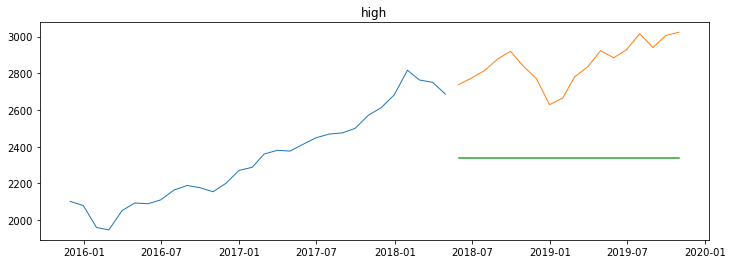

close -- RMSE: 520


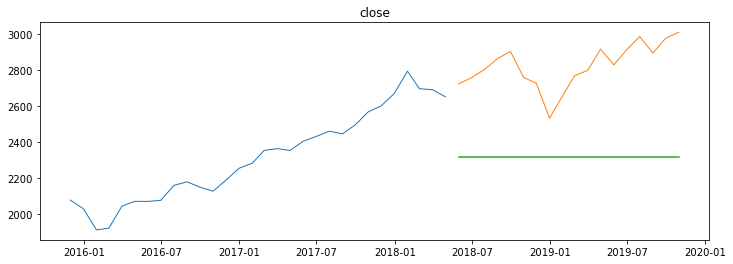

In [45]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [46]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '1month_moving_avg',
                            target_var = col)
    
eval_df

,model_type,target_var,rmse
0,last_observed_value,high,200.0
1,last_observed_value,close,209.0
2,simple_average,high,526.0
3,simple_average,close,520.0
4,1month_moving_avg,high,526.0
5,1month_moving_avg,close,520.0


In [48]:
periods = [1, 2, 3, 6, 12, 24]

for p in periods:
    close = round(train['close'].rolling(p).mean()[-1], 2)
    high = round(train['high'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'month_moving_avg'
    eval_df = append_eval_df(model_type = model_type,
                        target_var = 'high')
    eval_df = append_eval_df(model_type = model_type,
                        target_var = 'close')

In [49]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,high,200.0
1,last_observed_value,close,209.0
2,simple_average,high,526.0
3,simple_average,close,520.0
4,1month_moving_avg,high,526.0
5,1month_moving_avg,close,520.0
6,1month_moving_avg,high,200.0
7,1month_moving_avg,close,209.0
8,2month_moving_avg,high,175.0
9,2month_moving_avg,close,194.0


**Which is best so far?**

In [50]:
# get the min rmse for each variable

min_rmse_high = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_close = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_high) | 
         (eval_df.rmse == min_rmse_close)
        )]

,model_type,target_var,rmse
10,3month_moving_avg,high,163.0
13,6month_moving_avg,close,184.0


# Holt's Linear Trend


**Seasonal Decomposition**

In [51]:
import statsmodels.api as sm

high 



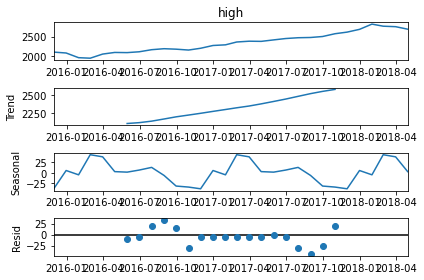

close 



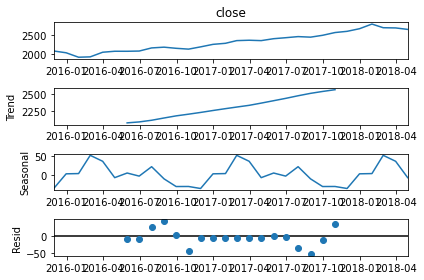

In [52]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

# Basic Holt's Linear Trend

**Make Predictions**

In [53]:
model = Holt(train['close'], exponential=False)
model = model.fit(optimized=True)
yhat_items = model.predict(start = validate.index[0],
                            end = validate.index[-1])
yhat_df['close'] = yhat_items

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [54]:
yhat_df.head()

,close,high
Date,,
2018-05-31,2673.268625,2414.54
2018-06-30,2693.547220,2414.54
2018-07-31,2713.825815,2414.54
2018-08-31,2734.104410,2414.54
2018-09-30,2754.383005,2414.54


In [55]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  """


In [56]:
yhat_df.head()

,close,high
Date,,
2018-05-31,2636.16,2681.80
2018-06-30,2672.50,2715.52
2018-07-31,2708.84,2749.24
2018-08-31,2745.19,2782.95
2018-09-30,2781.53,2816.67


high -- RMSE: 176


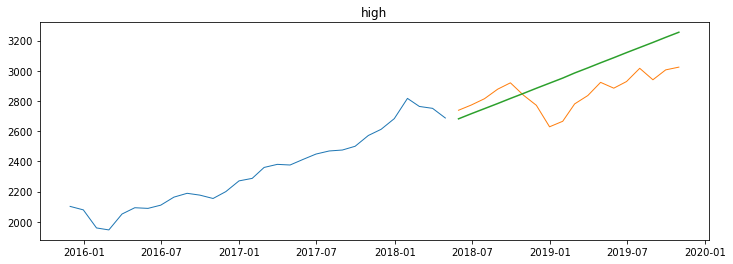

close -- RMSE: 195


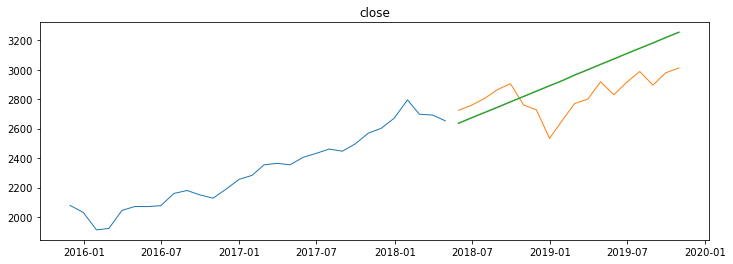

In [57]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [58]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_optimized', 
                             target_var = col)

In [59]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
10,3month_moving_avg,high,163.0
12,6month_moving_avg,high,175.0
8,2month_moving_avg,high,175.0
18,Holts_optimized,high,176.0
13,6month_moving_avg,close,184.0
11,3month_moving_avg,close,187.0
9,2month_moving_avg,close,194.0
19,Holts_optimized,close,195.0
6,1month_moving_avg,high,200.0
0,last_observed_value,high,200.0


- Let's do another model, changing some hyperparameters

In [60]:
for col in train.columns:
    model = Holt(train[col], exponential = False, damped=True)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  """


high -- RMSE: 150


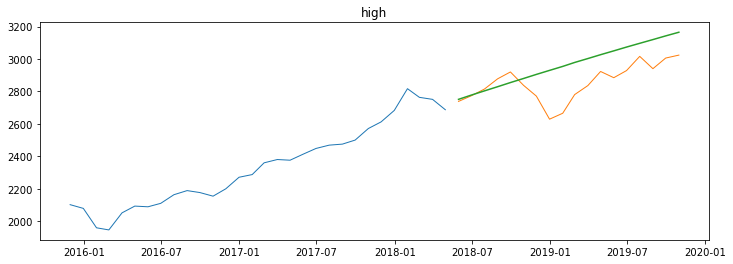

close -- RMSE: 161


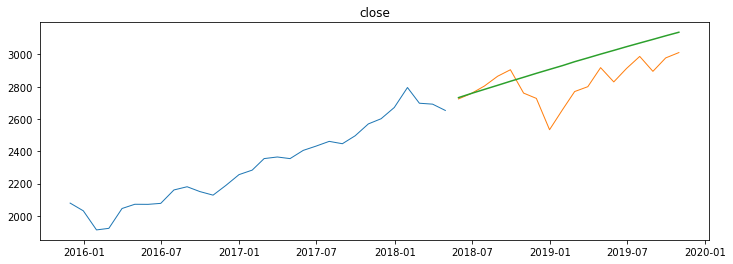

In [61]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [62]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_optimized_damped', 
                             target_var = col)

In [63]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
20,Holts_optimized_damped,high,150.0
21,Holts_optimized_damped,close,161.0
10,3month_moving_avg,high,163.0
12,6month_moving_avg,high,175.0
8,2month_moving_avg,high,175.0
18,Holts_optimized,high,176.0
13,6month_moving_avg,close,184.0
11,3month_moving_avg,close,187.0
9,2month_moving_avg,close,194.0
19,Holts_optimized,close,195.0


In [64]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .5, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  """


high -- RMSE: 256


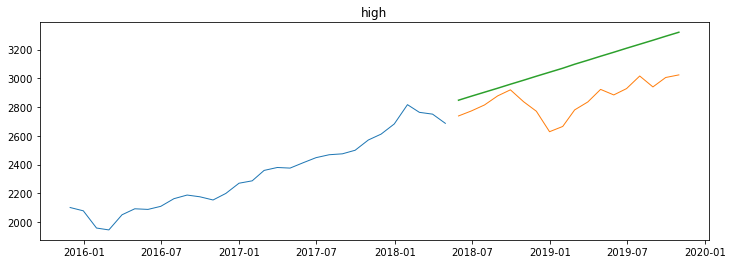

close -- RMSE: 153


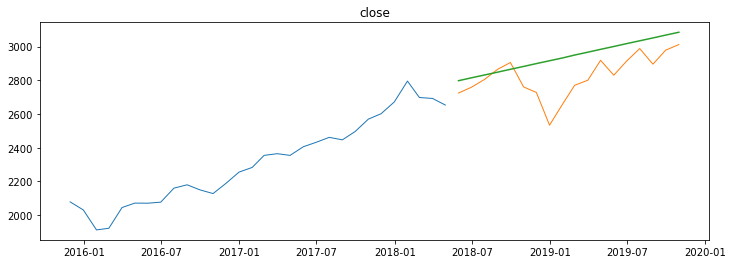

In [65]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [66]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_optimized_change_weight', 
                             target_var = col)

In [67]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
20,Holts_optimized_damped,high,150.0
23,Holts_optimized_change_weight,close,153.0
21,Holts_optimized_damped,close,161.0
10,3month_moving_avg,high,163.0
12,6month_moving_avg,high,175.0
8,2month_moving_avg,high,175.0
18,Holts_optimized,high,176.0
13,6month_moving_avg,close,184.0
11,3month_moving_avg,close,187.0
9,2month_moving_avg,close,194.0


# Predict Based on Previous Cycle

In [68]:
df.index.year.value_counts()

2019    12
2018    12
2017    12
2016    12
2020    10
2015     2
Name: Date, dtype: int64

In [69]:
train = df[:'2017']
validate = df['2018']
test = df['2019']

print(train.shape)
print(validate.shape)
print(test.shape)

(26, 2)
(12, 2)
(12, 2)


**Make Predictions**

In [70]:
train.diff(12).mean()

high     318.803571
close    329.479286
dtype: float64

In [71]:
train.head()

,high,close
Date,,
2015-11-30,2102.00,2078.64
2015-12-31,2079.02,2030.71
2016-01-31,1959.40,1912.37
2016-02-29,1946.31,1922.13
2016-03-31,2051.60,2045.12


In [74]:
yhat_df = train['2017'] + train.diff(12).mean()


In [75]:
pd.concat([yhat_df.head(1), validate.head(1)])


,high,close
Date,,
2017-01-31,2606.333571,2612.489286
2018-01-31,2817.020000,2794.940000


In [76]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

12

In [77]:
validate.head()

,high,close
Date,,
2018-01-31,2817.02,2794.94
2018-02-28,2763.68,2697.58
2018-03-31,2751.16,2691.93
2018-04-30,2687.25,2652.85
2018-05-31,2738.53,2724.16


In [78]:
train.head()

,high,close
Date,,
2015-11-30,2102.00,2078.64
2015-12-31,2079.02,2030.71
2016-01-31,1959.40,1912.37
2016-02-29,1946.31,1922.13
2016-03-31,2051.60,2045.12


In [79]:
df.index.year.value_counts()

2019    12
2018    12
2017    12
2016    12
2020    10
2015     2
Name: Date, dtype: int64

**Plot and evaluate**

high -- RMSE: 141


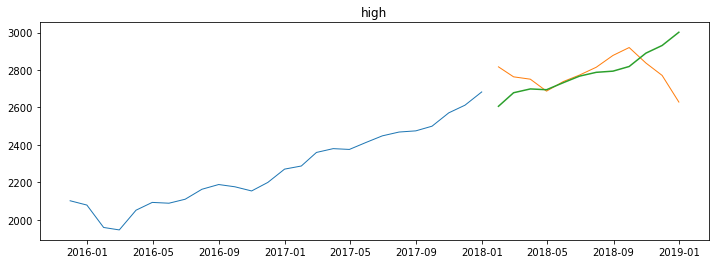

close -- RMSE: 165


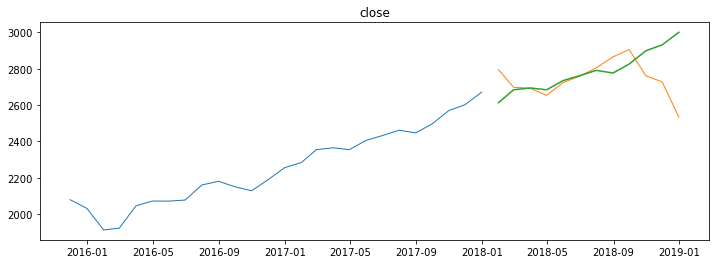

In [81]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [82]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
23,Holts_optimized_change_weight,close,153.0
24,previous year,high,141.0


/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


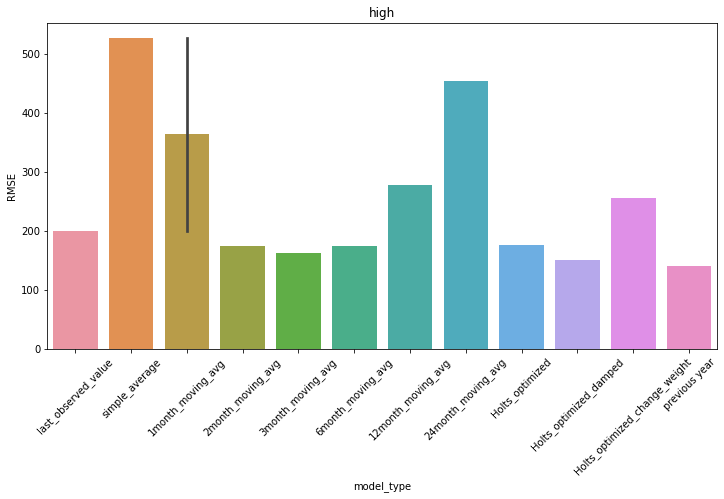

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


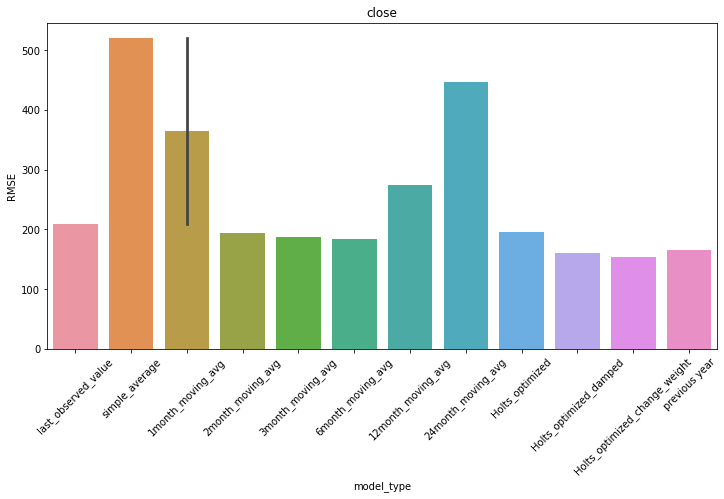

In [83]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()


**Let's test it out on our out-of-sample data**

**We will be using train + validate to predict test.**



In [84]:
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [85]:
rmse_high = round(sqrt(mean_squared_error(test['high'], yhat_df['high'])), 0)
rmse_close = round(sqrt(mean_squared_error(test['close'], yhat_df['close'])), 0)

In [86]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

rmse - high:  233.0
rmse - close:  244.0


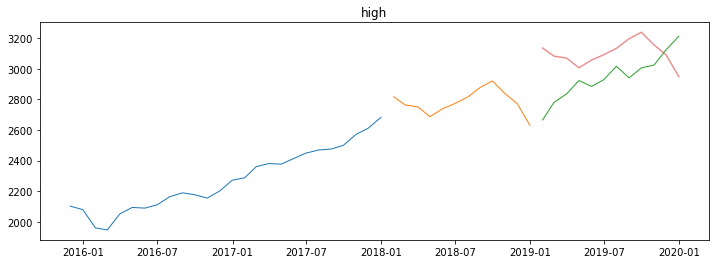

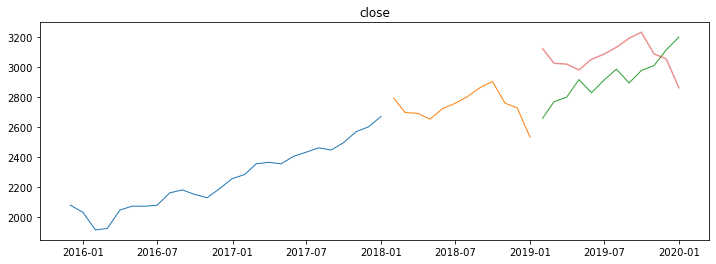

In [87]:
print("rmse - high: ", rmse_high)
print("rmse - close: ", rmse_close)

for col in train.columns:
    plot_and_eval(col)